In [1]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing


In [2]:
'''
Load dataset
'''
dt = pd.read_csv('central_west.csv')

In [ ]:
'''
Basic info about the dataset
'''

print(dt.shape)
dt.info()
dt.head()

Como podemos ver através do comando *shape* o *dataset* possui 11427120 linhas e 27 atributos.
Os atributos são todos do tipo numérico exceto os atributos "Data" e "Hora" que são do tipo String, e também os atributos "region","state","station" e "station_code".

Numa primeira análise podemos logo converter os atributos "Data" e "Hora" para objetos do tipo DateTime uma vez que irão providenciar mais informação ao modelo e serão mais fáceis de manipular para a exploração de dados.
Podemos tambem retirar a coluna "Index" uma vez que não é relevante para o problema e também a coluna "station" porque já temos o código correspondente.


In [3]:
dt['DataTime']= pd.to_datetime(dt['Data'] + dt['Hora'], format='%Y-%m-%d%H:%M')
dt.set_index('DataTime',inplace=True)

In [ ]:
dt['region'].value_counts(normalize=True)

Uma vez que o *dataset* corresponde a apenas uma região podemos também retirar a coluna *region* do mesmo.

In [4]:
dt.drop(["index","station","region","Hora","Data"],axis=1,inplace=True)

In [5]:
columns_renamed = {
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)' : 'pth',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)' : 'pah',
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)' : 'pahmax',
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)' : 'pahmin',
    'RADIACAO GLOBAL (Kj/m²)' : 'rad',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)' : 'dewh',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)' : 'dew',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)' : 'tempmax',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)' : 'tempmin',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)' : 'dewmax',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)' : 'dewmin',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)' : 'hummax',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)' : 'hummin',
    'UMIDADE RELATIVA DO AR, HORARIA (%)' : 'hum',
    'VENTO, DIREÇÃO HORARIA (gr) (° (gr))' : 'windgra',
    'VENTO, RAJADA MAXIMA (m/s)' : 'windmax',
    'VENTO, VELOCIDADE HORARIA (m/s)' : 'wind',
}
dt.rename(columns=columns_renamed, inplace=True)

In [ ]:
pd.set_option('display.max_columns', None)
dt.head()

Após a análise do *dataset* reparamos que o valor mínimo para os atributos era -9999 o que possivelmente indica *outliers*. 

Porém, não existem valores nulos nem NA, o que indica que estes valores são então considerados os valores que não foram medidos.

Deste modo, temos de os analisar para perceber se devemos retirar estes valores ou realizar outras operações.


In [ ]:
'''
Basic data exploration
'''

dt.isna().sum()

In [6]:
dt.replace(-9999.0, np.NaN, inplace=True)

In [ ]:
dt.describe()

In [ ]:
dt.isna().sum()

Como podemos observar, existem vários valores NaN o que necessita que façamos uma análise aos resultados para perceber se são valores pontuais que não foram lidos ou se fazem parte do "problema".
Para esse efeito, vamos primeiramente analisar os valores em falta por cada estação.


In [ ]:
pd.set_option('display.max_rows', None)
na_columns = dt.columns[dt.isna().any()].tolist()

dt_new = dt.isna().groupby(dt.station_code, dropna=False).sum()[na_columns]

In [ ]:
print(dt_new)

Para tentarmos analisar melhor a situação vamos centrar a atenção numa estação para percebermos os dados em falta.

In [ ]:
station_analysis_003 = dt.loc[dt['station_code'] == 'A003']

station_analysis_003.plot(y = 'dewh')



Através da visualização do plot conseguimos perceber que existem vários dados em falta na estação *A003*, que podem ser explicados pelo sensor de deteção se ter avariado.

Vamos tentar analisar uma estação com menos falhas e numa janela temporal mais reduzida. Iremos analisar as labels mais interessantes para o caso em estudo, ou seja, a temperatura, a humidade, a precipitação e a radiação.

In [ ]:
station_analysis_004 = dt.loc[dt['station_code'] == 'A027']

station_analysis_004_2weeks = station_analysis_004.loc[(station_analysis_004.index > '2016-03-01') & (station_analysis_004.index< '2016-03-10')]

station_analysis_004_2weeks.plot(y = 'dewh')
station_analysis_004_2weeks.plot(y = 'hum')
station_analysis_004_2weeks.plot(y = 'pth')
station_analysis_004_2weeks.plot(y = 'rad')

In [ ]:
st_004_temp = station_analysis_004['dewh']
st_004_temp.interpolate('linear', inplace=True, limit_direction='both')

st_004_temp[(st_004_temp.index > '2016-03-01') & (st_004_temp.index< '2016-03-10')].plot(y = 'dewh', figsize=(10,10))

Ao extrapolarmos a análise para um ano, podemos ver que a nível de temperatura os valores já estão normalizados e temos uma distribuição mais favorável ao modelo que vamos treinar.

Basta então realizar o mesmo processo de extrapolação para todos os atributos menos para os atributos "pth" e "rad" porque são reportados valores NaN quando deviam ser 0.


In [ ]:
station_analysis_004['pth'].fillna(0,inplace=True)
station_analysis_004['rad'].fillna(0,inplace=True)
station_analysis_004.index = pd.to_datetime(station_analysis_004.index)
station_analysis_004['mo'] = station_analysis_004.index.month
total_rain_004 = station_analysis_004.groupby('mo').mean().reset_index()
total_rain_004.plot(x='mo',y='pth',kind='bar')

In [ ]:
columns = ['pth','pah','pahmax','pahmin','rad','dewh','dew','tempmax','tempmin','dewmax','dewmin','hummax','hummin','hum','windgra','windmax','wind','latitude','height']

In [ ]:

station_analysis_004 = station_analysis_004[(station_analysis_004[columns] != 0).any(axis=1)]
station_analysis_004[columns] = station_analysis_004[columns].interpolate(method='linear')
station_analysis_004.isna().sum()




In [ ]:
station_analysis_004[(station_analysis_004.index > '2020-04-01') & (station_analysis_004.index < '2020-04-10')][['dew','wind','hum']].plot(figsize=(10,20))

In [ ]:
station_analysis = dt.loc[dt['station_code'] == 'A003']
station_analysis = station_analysis.set_index('Data') 

columns_st = station_analysis.select_dtypes('number').columns.tolist()
columns_st = [e for e in columns_st if e not in ('Hora','latitude','longitude','height')]

fig, axs = plt.subplots(nrows=len(columns_st), ncols = 1, figsize=(40, 30))

for ax,col_name in zip(axs, columns_st):
    ax.plot(station_analysis[col_name][:])
    ax.set(ylabel=col_name)
    ax.set_title([k for k, v in columns_renamed.items() if v == col_name][0])
    
fig.tight_layout(pad=1.0)
plt.show()



# Limpar o dataset inteiro

Após termos analisado ao detalhe uma estação completa, percebemos como os dados estão organizados e pudemos entender o significado dos NaN values que encontramos.

Deste modo, podemos extrapolar os resultados e intervenções que fizemos a apenas uma estação para todas as estações, ou seja, os valores de precipitação e radição a NaN devem ser colocados a 0 porque são indicativos de que o sensor não conseguir detetar porque não estavam presentes, enquanto que os outros valores em falta se devem ao facto de falhas temporárias nos sensores. Portanto, neste últimos mencionados, devemos fazer a interpolação para obtermos resultados melhores para treino.


In [ ]:
dt.isna().sum()

In [ ]:
(dt == 0).astype(int).sum(axis=0)

In [7]:
'''
Radiação e precipitação devem ser colocados a zero porque NAN indica que não houve registo desses valores dado que eram 0
'''
dt['pth'].fillna(0,inplace=True)
dt['rad'].fillna(0,inplace=True)

In [8]:
interpolate_columns = ['pah','pahmax','pahmin','dewh','dew','tempmax','tempmin','dewmax','dewmin','hummax','hummin','hum','windgra','windmax','wind']
dt[interpolate_columns] = dt[interpolate_columns].interpolate('linear')

In [ ]:
dt.isna().sum()

In [ ]:
dt.drop_duplicates()

#### Gráficos interessantes sobre os dados limpos

Concluida a limpeza dos dados, podemos tentar visualizar alguns gráficos para termos alguma noção sobre as distribuições e vermos quais são os atributos mais importantes.



In [ ]:

sns.distplot(dt['2016':]['pth'])

In [ ]:
sns.heatmap(dt.corr())

In [ ]:
fig, axs = plt.subplots(2,2, figsize =(10,20))

sns.distplot(dt['2016':]['pah'],ax = axs[0,0], kde=True)
sns.distplot(dt['2016':]['dewh'],ax = axs[0,1], kde=True)
sns.distplot(dt['2016':]['dew'],ax = axs[1,0], kde=True)
sns.distplot(dt['2016':]['hum'],ax = axs[1,1], kde=True)



In [ ]:
subset = dt['2016':'2020']
subset['mo'] = subset.index.month


fig, ax = plt.subplots()
sns.boxplot(x='mo',y='dewh',data=subset,ax=ax)
plt.title('Temperatura durante 4 anos por mês')




In [ ]:
sns.boxplot(x='mo',y='rad', data=subset)
plt.title("Radiação durante 4 anos por mês")

In [ ]:
sns.boxplot(x=subset.state, y="dewh", data=subset)
plt.title("Temperatura por estado")

In [9]:
x = dt['2016':].drop(['dewh'],axis=1)
y = dt['2016':]['dewh'].to_frame()

y.reset_index(drop=True,inplace=True)
x.reset_index(drop=True,inplace=True)
x.drop(['state','station_code','latitude','longitude','wind'],axis=1,inplace=True)
x.head()

,pth,pah,pahmax,pahmin,rad,dew,tempmax,tempmin,dewmax,dewmin,hummax,hummin,hum,windgra,windmax,height
0,0.0,899.6,900.0,899.6,3391.0,17.7,26.5,24.4,18.3,16.5,65.0,57.0,59.0,39.0,9.6,1043.0
1,0.0,899.2,899.6,899.2,3306.0,16.7,26.7,25.4,17.9,16.0,60.0,52.0,54.0,55.0,8.3,1043.0
2,0.0,898.6,899.2,898.6,3167.0,15.8,27.6,25.9,17.1,14.5,56.0,45.0,49.0,62.0,8.3,1043.0
3,0.0,897.7,898.6,897.7,3279.0,12.9,28.5,26.6,17.6,12.9,53.0,41.0,41.0,43.0,6.7,1043.0
4,0.0,897.0,897.7,897.0,2753.0,13.7,28.9,27.4,15.6,12.4,45.0,39.0,43.0,98.0,6.4,1043.0


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


X_train, X_test,y_train,y_test = train_test_split(x,y, test_size=0.3, random_state=2022)
#sns.distplot(y_train)

/tmp/ipykernel_1542/2957397977.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test)


<AxesSubplot: ylabel='Density'>

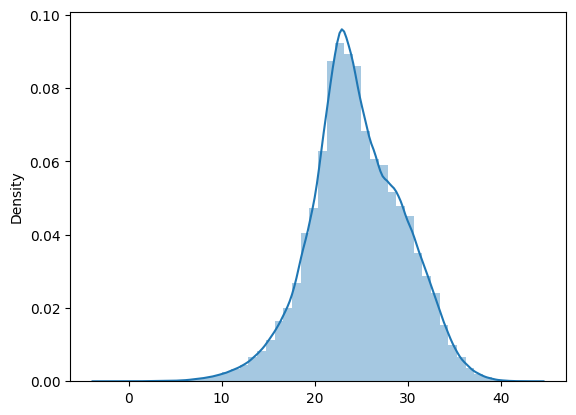

In [35]:
sns.distplot(y_test)

In [ ]:
lm = LinearRegression()
lm.fit(X_train,y_train)

In [ ]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)

In [ ]:
from sklearn import metrics
print('MSE', metrics.mean_squared_error(y_test, predictions))

In [11]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
model = DecisionTreeRegressor(random_state=2022)


In [ ]:
model.fit(X_train,y_train)
predictions = model.predict(X_test)

In [ ]:
mean_squared_error(y_test, predictions,squared=True)

In [15]:
from sklearn.model_selection import GridSearchCV, ParameterGrid


#mean_absolute_error(y_test, predictions)
#mean_squared_error(y_test,predictions)
gs = GridSearchCV(model, param_grid = ParameterGrid({'min_samples_split': [[min_samples_split] for min_samples_split in np.arange(0,1,0.025)]}),n_jobs=-1,cv=5,scoring='r2')
gs.fit(X_train,y_train)




/home/shiiva/Desktop/master/daa/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/shiiva/Desktop/master/daa/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/shiiva/Desktop/master/daa/env/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 1342, in fit
    super().fit(
  File "/home/shiiva/Desktop/master/daa/env/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 273, in fit
    check_scala

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=2022),
             n_jobs=-1,
             param_grid=<sklearn.model_selection._search.ParameterGrid object at 0x7f40a05b90f0>,
             scoring='r2')

In [16]:
print(gs.best_score_)
print(gs.best_params_)


0.9762719363204176
{'min_samples_split': 0.025}


In [37]:
from sklearn.model_selection import GridSearchCV, ParameterGrid


#mean_absolute_error(y_test, predictions)
#mean_squared_error(y_test,predictions)
gssq = GridSearchCV(model, param_grid = ParameterGrid({'min_samples_split': [[min_samples_split] for min_samples_split in np.arange(0,1,0.025)]}),n_jobs=-1,cv=5,scoring='neg_mean_squared_error')
gssq.fit(X_train,y_train)


/home/shiiva/Desktop/master/daa/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/shiiva/Desktop/master/daa/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/shiiva/Desktop/master/daa/env/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 1342, in fit
    super().fit(
  File "/home/shiiva/Desktop/master/daa/env/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 273, in fit
    check_scala

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=2022),
             n_jobs=-1,
             param_grid=<sklearn.model_selection._search.ParameterGrid object at 0x7f40844bada0>,
             scoring='neg_mean_squared_error')

In [39]:
print(gssq.best_score_)
print(gssq.best_params_)

-0.5874799471400737
{'min_samples_split': 0.025}


In [12]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
gs2 = GridSearchCV(model, param_grid = ParameterGrid({'min_samples_leaf': [[min_samples_split] for min_samples_split in np.arange(0.000001,0.5,0.025)]}),n_jobs=-1,cv=5,scoring='r2')

In [13]:
gs2.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=2022),
             n_jobs=-1,
             param_grid=<sklearn.model_selection._search.ParameterGrid object at 0x7f4078597550>,
             scoring='r2')

In [14]:
print(gs2.best_score_)
print(gs2.best_params_)

0.9942708814434841
{'min_samples_leaf': 1e-06}


In [29]:
best_model = DecisionTreeRegressor(random_state=2022, min_samples_split=0.025, min_samples_leaf=1e-06,max_depth=9)
best_model.fit(X_train,y_train)
predictions = best_model.predict(X_test)


In [40]:
from sklearn.metrics import r2_score, mean_squared_error


#mean_squared_error(y_test, predictions,squared=True)
r2_score(y_test,predictions)
mean_squared_error(y_test,predictions,squared=True)


0.5842490117619297

In [23]:
print(best_model.get_depth())

9


In [24]:
max_depth_grid = GridSearchCV(model, param_grid = ParameterGrid({'max_depth': [[max_depth] for max_depth in np.arange(1,10)]}),n_jobs=-1,cv=5,scoring='r2')

In [25]:
max_depth_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=2022),
             n_jobs=-1,
             param_grid=<sklearn.model_selection._search.ParameterGrid object at 0x7f40473525f0>,
             scoring='r2')

In [28]:
print(max_depth_grid.best_score_)
print(max_depth_grid.best_params_)

0.985652541287832
{'max_depth': 9}
